## Weather Data : Initial Visualization

### For New York State

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [45]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

_figsize=(10,7)

## Read Data

### Read Raw data for state

In [3]:
state='NY'
data_dir='../../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/NY.tgz > ../../Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.1M  100 22.1M    0     0  4912k      0  0:00:04  0:00:04 --:--:-- 5498k
-rw-r--r--  1 yoavfreund  staff    22M Apr 10 14:21 ../../Data/Weather/NY.tgz


In [ ]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du ./$parquet
%cd $cur_dir

In [47]:
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
weather_df=weather_df.drop('State')
print('number of rows=',weather_df.count())
weather_df.show(5)

number of rows= 84199
+-----------+-----------+----+--------------------+
|    Station|Measurement|Year|              Values|
+-----------+-----------+----+--------------------+
|USC00303452|       PRCP|1903|[00 7E 00 7E 00 7...|
|USC00303452|       PRCP|1904|[00 00 28 5B 00 0...|
|USC00303452|       PRCP|1905|[00 00 60 56 60 5...|
|USC00303452|       PRCP|1906|[00 00 00 00 00 0...|
|USC00303452|       PRCP|1907|[00 00 00 00 60 5...|
+-----------+-----------+----+--------------------+
only showing top 5 rows



### read statistics information for state.

In [48]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/STAT_NY.pickle.gz > ../../Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.2M  100 14.2M    0     0  7768k      0  0:00:01  0:00:01 --:--:-- 7764k


In [50]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath
!gunzip -f $gzpath

../../Data/Weather/STAT_NY.pickle.gz
ls: ../../Data/Weather/STAT_NY.pickle.gz: No such file or directory
gunzip: can't stat: ../../Data/Weather/STAT_NY.pickle.gz (../../Data/Weather/STAT_NY.pickle.gz.gz): No such file or directory


In [51]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'))
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS'])


In [52]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

### Read information about US weather stations.

In [53]:
filename='Weather_stations.tgz'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/Info/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/Info/Weather_stations.tgz > ../../Data/Weather/Weather_stations.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   304    0   304    0     0   1876      0 --:--:-- --:--:-- --:--:--  1876


In [54]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Data/Weather
tar: Unrecognized archive format
tar: Error exit delayed from previous errors.
56480	NY.parquet
8512	US_Weather_BBSSBBSS.parquet
9584	decon_NY_SNWD.parquet
4808	decon_SSSSBBBB_SNWD.parquet
9584	recon_NY_SNWD.parquet
840	stations.parquet
/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section2-PCA/PCA


In [57]:
!rm -rf $data_dir/*.?gz
!du -sh $data_dir/*

 28M	../../Data/Weather/NY.parquet
 24M	../../Data/Weather/STAT_NY.pickle
4.7M	../../Data/Weather/decon_NY_SNWD.parquet
4.7M	../../Data/Weather/recon_NY_SNWD.parquet
420K	../../Data/Weather/stations.parquet


In [11]:
stations_df = sqlContext.createDataFrame(stations,schema)
stations_df.show(5)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00044534|   107.655| 36.0042|  -119.96|     73.2|   CA|  KETTLEMAN CITY|
|USC00356784|   0.61097| 42.7519|-124.5011|     12.8|   OR|PORT ORFORD NO 2|
|USC00243581|   1316.54| 47.1064|-104.7183|    632.8|   MT|        GLENDIVE|
|USC00205601|   685.501|   41.75| -84.2167|    247.2|   MI|         MORENCI|
|CA005010480|   908.271|  49.917|   -99.95|    409.0|  NaN| BRANDON AIRPORT|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [76]:
jdf=weather_df.join(stations_df,on='Station',how='left')
jdf.select(['Station','Name','Year','State','Dist_coast']).show(4)

+-----------+-------+----+-----+----------+
|    Station|   Name|Year|State|Dist_coast|
+-----------+-------+----+-----+----------+
|USC00303955|HONEOYE|1992|   NY|   362.277|
|USC00303955|HONEOYE|1993|   NY|   362.277|
|USC00303955|HONEOYE|1994|   NY|   362.277|
|USC00303955|HONEOYE|1995|   NY|   362.277|
+-----------+-------+----+-----+----------+
only showing top 4 rows



In [70]:
jdf.columns

['Station',
 'Measurement',
 'Year',
 'Values',
 'Dist_coast',
 'Latitude',
 'Longitude',
 'Elevation',
 'State',
 'Name']

In [71]:
sqlContext.registerDataFrameAsTable(jdf,'jdf')

#find the stations in NY with the most measurements.
sqlContext.sql('select Name,count(Name) as count from jdf GROUP BY Name ORDER BY count DESC').show(5)

+--------------------+-----+
|                Name|count|
+--------------------+-----+
|     SETAUKET STRONG|  719|
|NEW YORK CNTRL PK...|  715|
|            LOWVILLE|  705|
|              ELMIRA|  704|
|            ANGELICA|  703|
+--------------------+-----+
only showing top 5 rows



In [72]:
#find how many measurements of each type for a particlar station
stat='ELMIRA'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|       TMIN|  120|
|       TOBS|  113|
|       TMAX|  120|
|       SNOW|  121|
|       SNWD|  109|
|       PRCP|  121|
+-----------+-----+



In [62]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

+----+-----+
|Year|count|
+----+-----+
|1924|    6|
|1959|    6|
|1975|    6|
|1990|    6|
|1977|    6|
+----+-----+
only showing top 5 rows



In [65]:
# get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year)
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

,Station,Year,Values,Dist_coast,Latitude,Longitude,Elevation,State,Name
Measurement,,,,,,,,,
PRCP,USC00302610,2007,"[0, 69, 0, 0, 0, 0, 0, 72, 128, 86, 0, 66, 112...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNOW,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNWD,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TMAX,USC00302610,2007,"[160, 86, 160, 86, 160, 86, 40, 88, 128, 88, 9...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TMIN,USC00302610,2007,"[0, 0, 128, 209, 0, 207, 0, 0, 128, 84, 128, 7...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TOBS,USC00302610,2007,"[0, 0, 64, 204, 0, 0, 224, 85, 160, 87, 64, 76...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA


## Plots

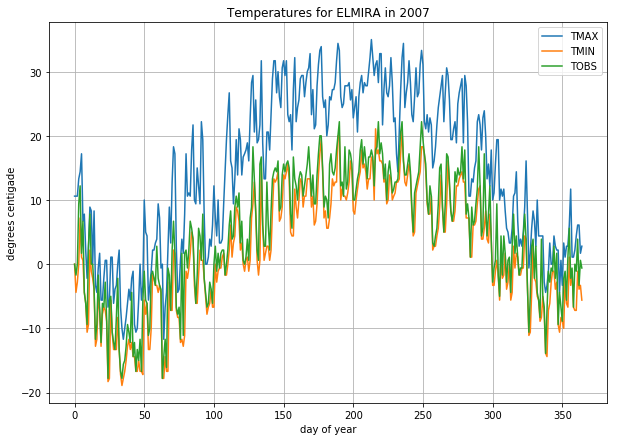

In [66]:
_tmax=unpackArray(pandas_df.loc['TMAX','Values'],np.float16)/10.
_tmin=unpackArray(pandas_df.loc['TMIN','Values'],np.float16)/10.
_tobs=unpackArray(pandas_df.loc['TOBS','Values'],np.float16)/10.
figure(figsize=_figsize)
plot(_tmax,label='TMAX');
plot(_tmin,label='TMIN');
plot(_tobs,label='TOBS');
xlabel('day of year')
ylabel('degrees centigade')
title('Temperatures for %s in %d'%(stat,year))
legend()
grid()

### Script for plotting yearly plots

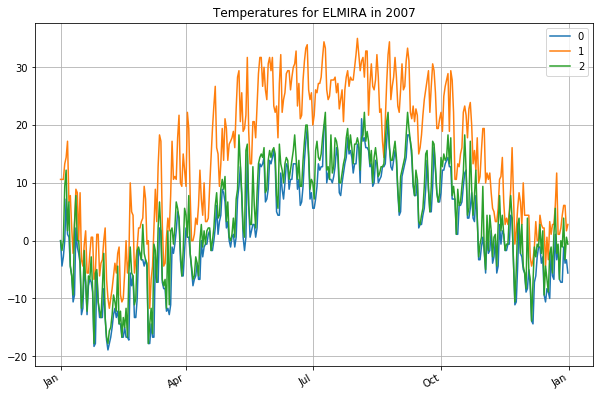

In [68]:
from lib.YearPlotter import YearPlotter
T=np.stack([_tmin,_tmax,_tobs])

fig, ax = plt.subplots(figsize=_figsize);
YP=YearPlotter()
YP.plot(T.transpose(),fig,ax,title='Temperatures for %s in %d'%(stat,year));
plt.savefig('percipitation.png')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [25]:
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)
    

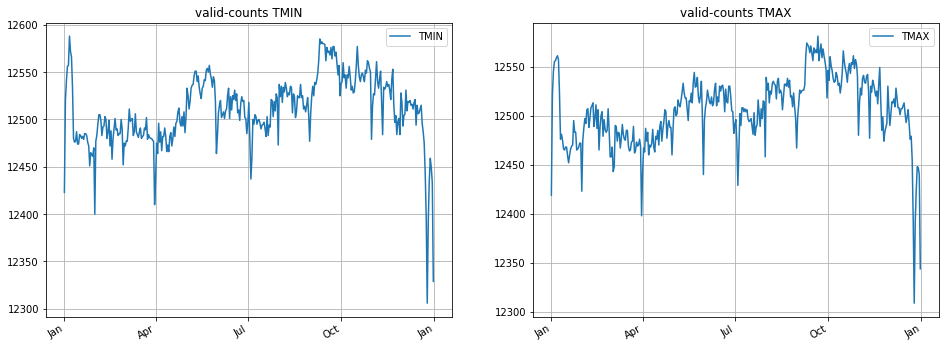

In [26]:
plot_pair(['TMIN','TMAX'],plot_valid)

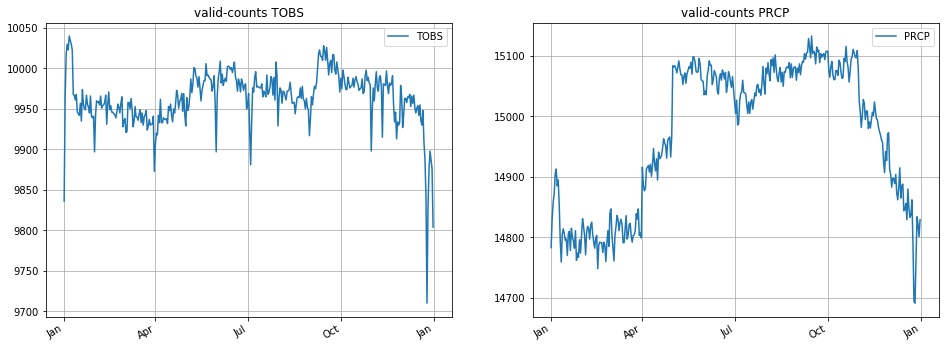

In [27]:
plot_pair(['TOBS','PRCP'],plot_valid)

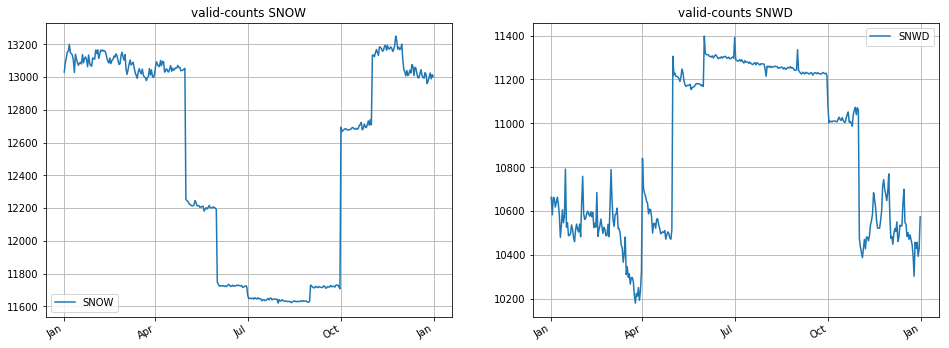

In [28]:
# Note that for "SNOW" there are more missing measurements in the summer
# While for SNWD there are less missing in the summer
# Question: do these anomalies involve the same stations?
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [29]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



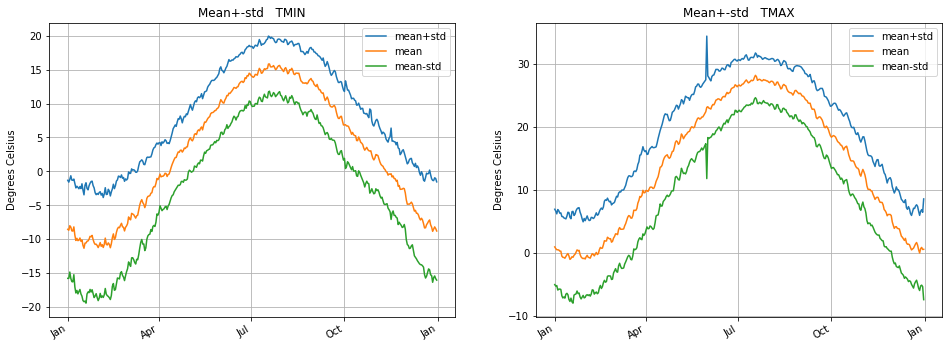

In [30]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

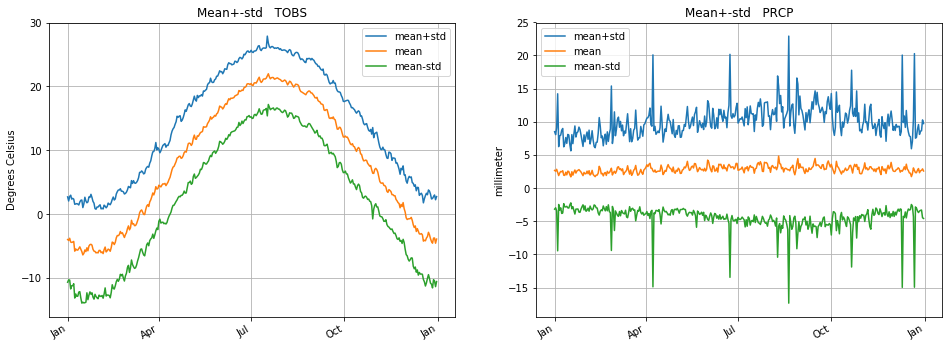

In [31]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

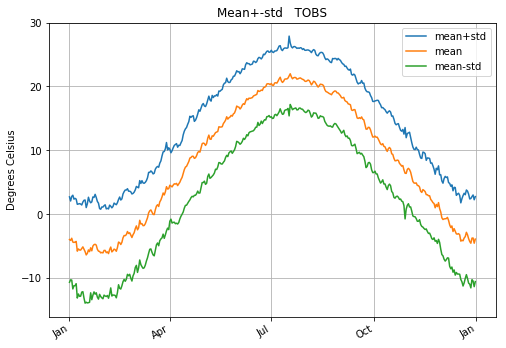

In [32]:
plot_single('TOBS',plot_mean_std,'r_figures/TOBS.png')

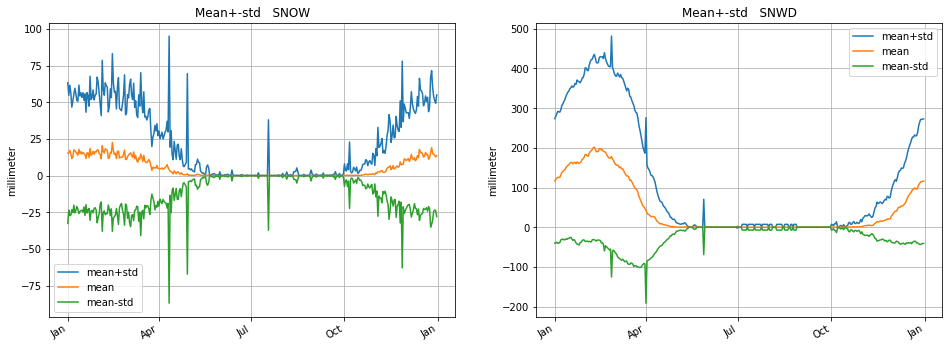

In [33]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### Plotting percentage of variance explained by Eigen-vectors

In [73]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

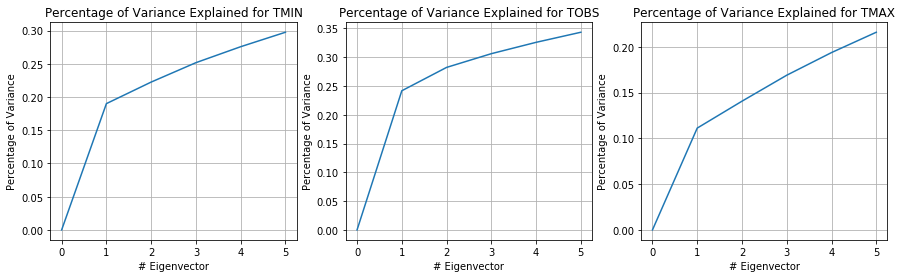

In [74]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

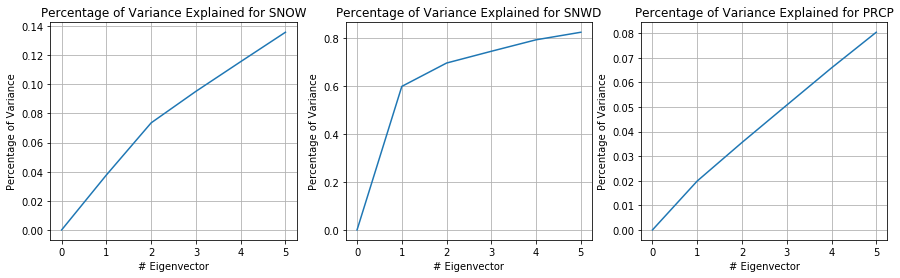

In [75]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png')

### plotting top 3 eigenvectors

In [36]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

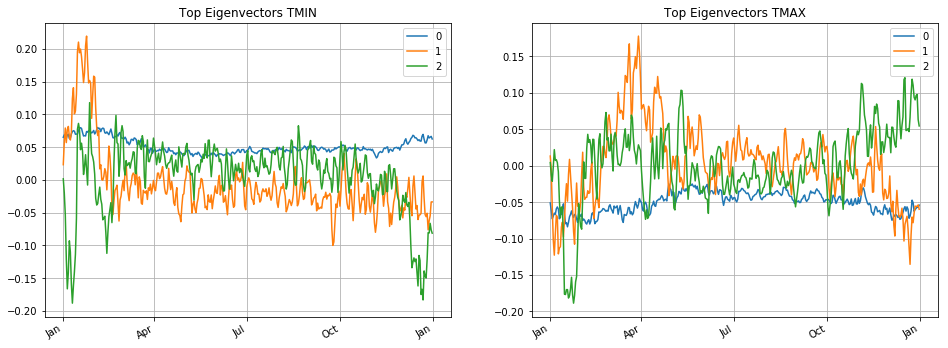

In [37]:
plot_pair(['TMIN','TMAX'],plot_eigen)

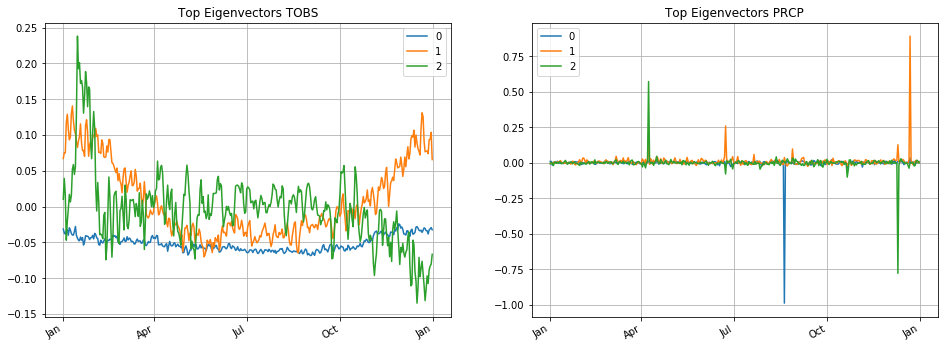

In [38]:
plot_pair(['TOBS','PRCP'],plot_eigen)

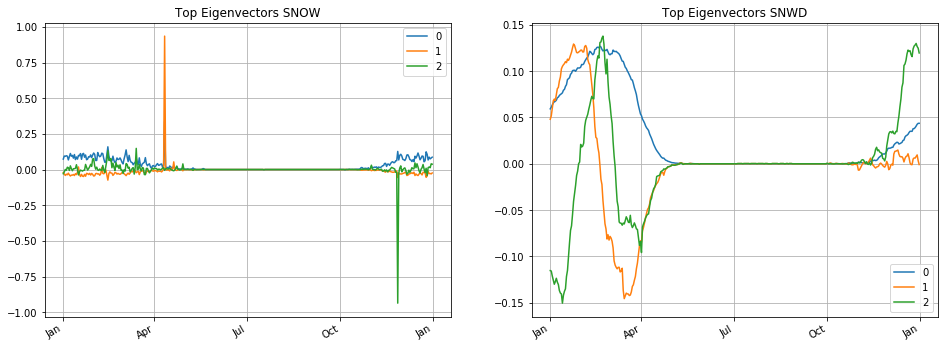

In [39]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

## Summary
We saw how to plot:
* Data from several (Station,Year,Measurement)
* The mean+-std for a particular (Station,Measurement)
* The percentage of cariance explained by top eigen-vectors.
* The top eigen-vectors